In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.linear_model import LinearRegression
from sklearn import svm

from matplotlib import rc

import matplotlib as mpl

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['savefig.dpi'] = 300

mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 30

rc('text', usetex=True)

import os
import datetime

import warnings
from scipy import interpolate
from scipy.stats import linregress

warnings.filterwarnings('ignore')

In [2]:
def compute_GDD_w_opt_max(T, T_base, T_opt, T_max):
    
    GDD = np.zeros(len(T))
    
    m = - (T_opt - T_base) / (T_max - T_opt)
    n = -m * T_max
    
    for i in range(len(T)):
        
        if T[i] < T_base:
            
            pass
        
        elif T[i] <= T_opt:
            
            GDD[i] += T[i] - T_base
            
        elif T[i] <= T_max:
            
            
            GDD[i] += m*T[i] + n
            
    return GDD

def compute_GDD_w_opt_max_i(T, T_base, T_opt, T_max):
    
    m = - (T_opt - T_base) / (T_max - T_opt)
    n = -m * T_max
     
    if T < T_base:

        return 0.0

    elif T <= T_opt:

        return T - T_base

    elif T <= T_max:


        return m*T + n
    
    else:
    
        return 0.0


def compute_GDD_opt_max(filename, T_base, T_opt, T_max, T_base_CDD=7):
    
    df = pd.read_csv(filename)
    
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    
    df["GDD"] = compute_GDD_w_opt_max(df["Temperature"].values, T_base, T_opt, T_max)
    df["CDD"] = (T_base_CDD - df["Temperature"]).apply(lambda x: x if x > 0 else 0)
    
    GDD = df.resample('D', on="Date").mean()
    
    return GDD

def compute_GDD_range(df, start, end):
    
    return df[(df.index >= start) & (df.index <= end)]["GDD"].sum()

def compute_CDD_range(df, start, end):
    
    return df[(df.index >= start) & (df.index <= end)]["CDD"].sum()

def compute_avg_humidity_range(df, start, end):
    
    return df[(df.index >= start) & (df.index <= end)]["Humidity"].mean()

def compute_avg_temperature_range(df, start, end):
    
    return df[(df.index >= start) & (df.index <= end)]["Temperature"].mean()

def egg_hatching_GDD_opt_max(filename, T_base, T_opt, T_max, T_base_CDD, loc, filename_results="Resultados GD.xlsx"):
    
    df = compute_GDD_opt_max(filename, T_base, T_opt, T_max, T_base_CDD)
    
    eggs = pd.read_excel(filename_results)

    eggs.sort_values(by="Fecha puesta")
    
    eggs_loc = eggs[eggs["Localización"] == loc]
    
    GDD_eclosion = []
    CDD_eclosion = []
    avg_humidity = []
    avg_temperature = []

    for i in range(len(eggs_loc)):

        start = eggs_loc.iloc[i]["Fecha puesta"]
        end = eggs_loc.iloc[i]["Fecha emergencia"]

        if not type(start) == str:

            GDD_eclosion.append(compute_GDD_range(df, start, end))
            CDD_eclosion.append(compute_CDD_range(df, start, end))
            
            avg_humidity.append(compute_avg_humidity_range(df, start, end))
            avg_temperature.append(compute_avg_temperature_range(df, start, end))
            
    eggs_loc["GDD_eclosion"] = GDD_eclosion
    eggs_loc["CDD_eclosion"] = CDD_eclosion
    eggs_loc["Humidity_eclosion"] = avg_humidity
    eggs_loc["Temperature_eclosion"] = avg_temperature
    
    return eggs_loc

def construct_df_opt_max(filenames, locs, T_base=7, T_opt=25, T_max=35, T_base_CDD=7, filename_results="Resultados GD.xlsx"):
    
    for filename, loc in zip(filenames, locs):
            
        if filename == filenames[0]:
            
            df = egg_hatching_GDD_opt_max("Processed_climatic_data/%s" % filename, T_base, T_opt,
                                      T_max, T_base_CDD, loc, filename_results)
        else:

            df_new = egg_hatching_GDD_opt_max("Processed_climatic_data/%s" % filename, T_base, T_opt,
                                          T_max, T_base_CDD, loc, filename_results)

            df = df.append(df_new, ignore_index=True)
            
    return df

def sigmoid(x, x0, k):
    
    y = 1 / (1 + np.exp(-k*(x-x0)))
    
    return (y)

def egg_hatching_probability(df, T_base, T_opt, T_max, N_points=40):
    
    GDD_max = np.amax(df["GDD_eclosion"])

    GDD_slices = np.linspace(0, GDD_max, N_points)

    ninfas = []

    for item in GDD_slices:

        ninfas.append(df[df["GDD_eclosion"] < item]["Numero ninfas"].sum())

    ninfas = ninfas / ninfas[-1]

    p0 = [np.median(GDD_slices), -0.01] # this is an mandatory initial guess

    popt, pcov = curve_fit(sigmoid, GDD_slices, ninfas, p0, method='dogbox')
    
    return ninfas, GDD_slices, popt
    

def plot_accumulated_GDD(filename):

    GDD = compute_GDD(filename, 10)

    accumulated_GDD = []

    GDD_vals = GDD["GDD"].values

    for i in range(len(GDD_vals)):

        accumulated_GDD.append(np.sum(GDD_vals[0:i]))

    plt.figure(figsize=(12, 8))

    plt.plot(GDD.index, accumulated_GDD)

#  Create final df

In [3]:
df_puestas = pd.read_excel("Puesta ICA (cruces 2021).xlsx")

filenames = ['Ensayo_filenus_BUSTARVIEJO.csv',
       'Ensayo_filenus_IMIDRA.csv', 'Ensayo_filenus_MATAELPINO.csv',
       'Ensayo_filenus_PEDREZUELA.csv']#, 'Ensayo_filenus_ICA.csv'] #np.sort(os.listdir("Processed_climatic_data"))

locs = ["bustarviejo", "encin", "mataelpino", "pedrezuela"]#, "ICA"]

T_base = 9.2
T_opt = 24.1
T_base_CDD = 7
T_max = 35.9

#df = construct_df(filenames, locs, T_base, T_opt, T_base_CDD)
df = construct_df_opt_max(filenames, locs, T_base, T_opt, T_max, T_base_CDD,
                          filename_results="Resultados GD.xlsx")

#df.iloc[:, 0:4].head().to_csv("HEAD.csv")
df = df.sort_values(by="Fecha puesta")

df["Days to emergence"] = df["Fecha emergencia"] - df["Fecha puesta"]

df["Days to emergence"] = [i.days for i in df["Days to emergence"]]

df

,Fecha emergencia,Fecha puesta,Localización,Numero ninfas,GDD_eclosion,CDD_eclosion,Humidity_eclosion,Temperature_eclosion,Days to emergence
48,2021-03-31,2020-10-08,mataelpino,2,234.449685,255.871147,70.467933,8.954758,174
46,2021-03-26,2020-10-08,mataelpino,1,213.797372,255.360730,71.192209,8.728581,169
54,2021-04-04,2020-10-08,mataelpino,4,246.756783,256.350314,70.366854,9.096398,178
20,2021-04-21,2020-10-08,bustarviejo,11,286.038413,502.955579,81.411512,7.828554,195
28,2021-03-05,2020-10-08,encin,8,289.341423,334.556610,81.568321,8.381311,148
...,...,...,...,...,...,...,...,...,...
65,2021-04-21,2020-11-04,mataelpino,3,257.722708,259.819064,69.992266,9.269812,168
63,2021-04-17,2020-11-04,mataelpino,2,245.620448,258.246147,70.038796,9.176732,164
19,2021-04-13,2020-11-04,bustarviejo,1,170.808720,473.028071,84.509344,7.048063,160
45,2021-03-26,2020-11-04,mataelpino,2,184.541934,253.714897,70.665910,8.445975,142


In [4]:
new_df = pd.DataFrame(columns=df.columns)

k = 0

for i in range(len(df)):
    
    N_obs = df.iloc[i]["Numero ninfas"]
    
    for j in range(N_obs):
        
        new_df.loc[k] = df.iloc[i]
        
        k += 1
        
final_df = new_df.drop(["Numero ninfas"], axis=1)

final_df["Fecha emergencia"] = pd.to_datetime(final_df["Fecha emergencia"])

new_df_puestas = pd.DataFrame(columns=df_puestas.columns)

k = 0

for i in range(len(df_puestas)):
    
    N_obs = df_puestas.iloc[i]["PUESTAS"]
    
    for j in range(N_obs):
        
        new_df_puestas.loc[k] = df_puestas.iloc[i]
        
        k += 1
        
final_df_puestas = new_df_puestas.drop(["PUESTAS"], axis=1)

final_df_puestas["FECHA"] = pd.to_datetime(final_df_puestas["FECHA"])

# Egg laying and egg hatching 

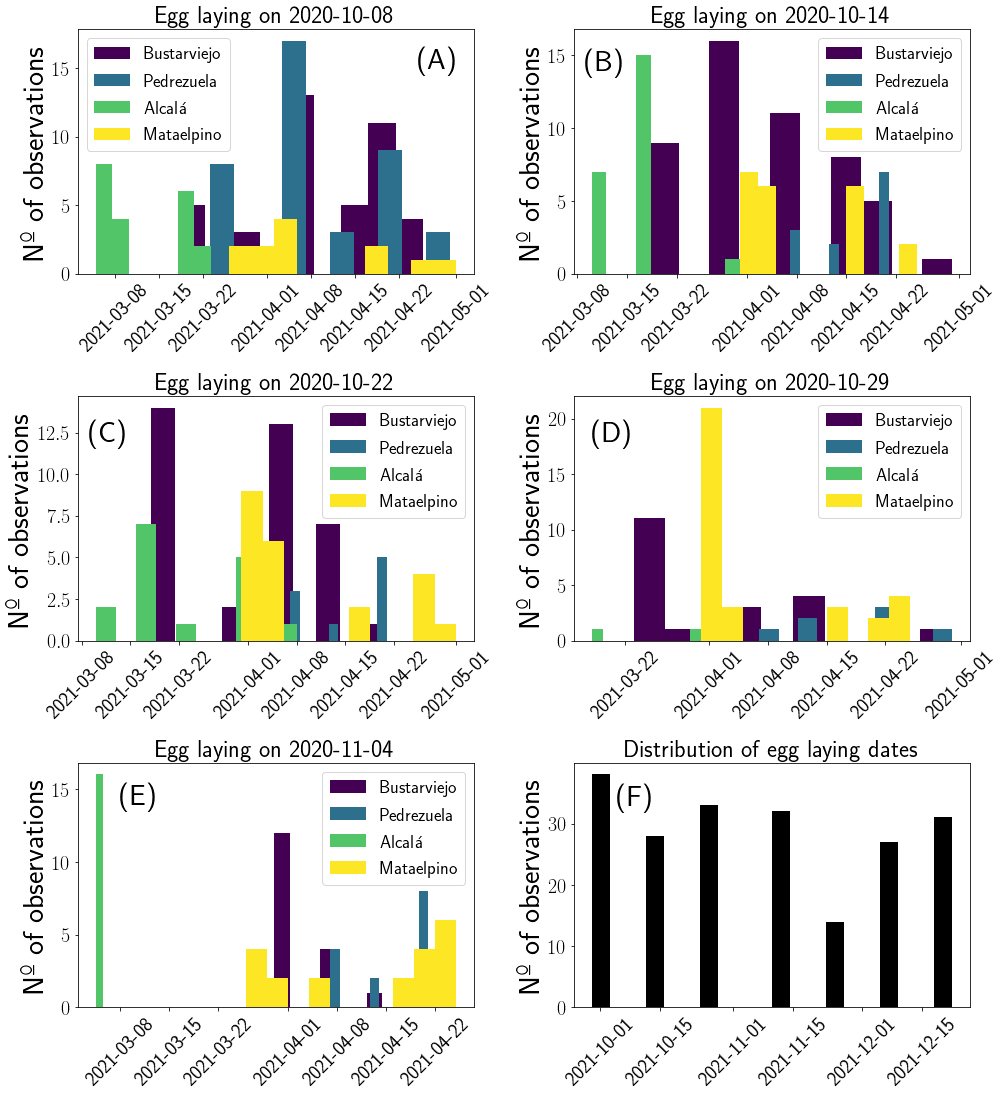

In [5]:
fechas_puestas = np.unique(final_df["Fecha puesta"])
locs = ['bustarviejo', 'pedrezuela', 'encin', 'mataelpino'] #np.unique(final_df["Localización"])
labels = ["Bustarviejo", "Pedrezuela", "Alcalá", "Mataelpino"]

colors = plt.get_cmap("viridis", 12)

fig, ax = plt.subplot_mosaic(
"""
AB
CD
EF
""", figsize=(8*2, 6*3))

letters = ["A", "B", "C", "D", "E", "F"]

for k in range(len(fechas_puestas)):

    for i in range(4):

        final_df_fecha_puesta_i_loc_j = final_df["Fecha emergencia"][
            (final_df["Fecha puesta"]==fechas_puestas[k]) & (final_df["Localización"]==locs[i])]
        
        if (k==4) & (i == 2):
            
            ax[letters[k]].hist(final_df_fecha_puesta_i_loc_j, color=colors(i*4), label=labels[i], bins=1)
            
        else:
            
            ax[letters[k]].hist(final_df_fecha_puesta_i_loc_j, color=colors(i*4), label=labels[i])

        ax[letters[k]].tick_params("x", rotation=45)
        ax[letters[k]].set_ylabel("Nº of observations")
        
        ax[letters[k]].set_title("Egg laying on %s" % pd.to_datetime(fechas_puestas[k]).strftime('%Y-%m-%d'))
        
        ax[letters[k]].legend(fontsize=18)
        
ax["A"].text(datetime.datetime(2021, 4, 25), 15, "(A)", fontsize=30)
ax["B"].text(datetime.datetime(2021, 3, 9), 14, "(B)", fontsize=30)
ax["C"].text(datetime.datetime(2021, 3, 9), 12, "(C)", fontsize=30)
ax["D"].text(datetime.datetime(2021, 3, 18), 18, "(D)", fontsize=30)
ax["E"].text(datetime.datetime(2021, 3, 8), 14, "(E)", fontsize=30)
ax["F"].text(datetime.datetime(2021, 10, 5), 33, "(F)", fontsize=30)

ax["F"].hist(final_df_puestas["FECHA"], bins=20, color='k')
ax["F"].tick_params("x", rotation=45)
ax["F"].set_ylabel("Nº of observations")
ax["F"].set_title("Distribution of egg laying dates")
        
plt.subplots_adjust(hspace=0.5, wspace=0.25)

#plt.savefig("Distribucion_puestas_emergencias.pdf", bbox_inches='tight', dpi=300)

# Relation between GDD and Humidity 

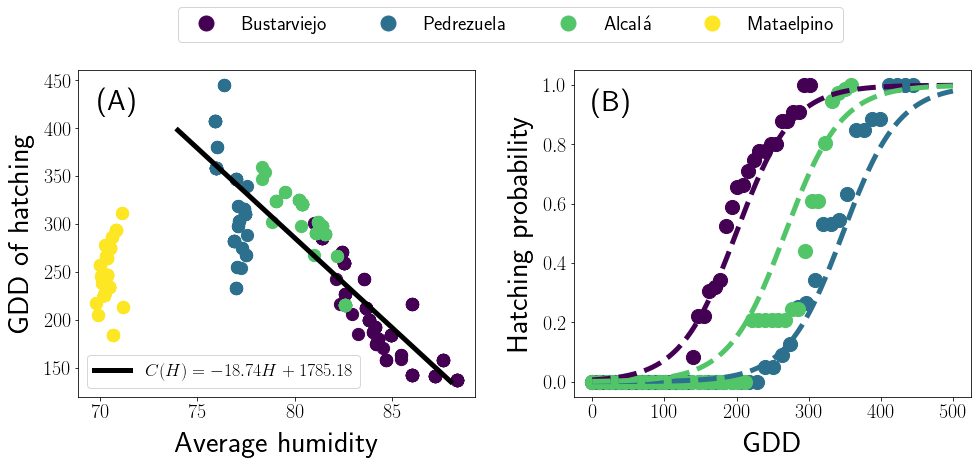

In [6]:
locs = ["bustarviejo", "pedrezuela", "encin", "mataelpino"]
labels = ["Bustarviejo", "Pedrezuela", "Alcalá", "Mataelpino"]

x_reg = final_df["Humidity_eclosion"][final_df["Localización"] != "mataelpino"]
y_reg = final_df["GDD_eclosion"][final_df["Localización"] != "mataelpino"]

xx = np.linspace(74, 88, 1000)

slope, intercept, r, p, se = linregress(x_reg, y_reg)

colors = plt.get_cmap("viridis", 12)

fig, axs = plt.subplot_mosaic([['a', 'd']],
                              constrained_layout=True, figsize=(16, 6))

x_GDD = np.linspace(0, 500, 1000)

C_H = [196.80101857, 330.89726939, 290.00168378, 247.1746239]

for i in range(4):
    
    df_bust = df[df["Localización"] == locs[i]]

    ninfas, GDD_slices, popt = egg_hatching_probability(df_bust, T_base, T_opt, T_max, N_points=40)

    axs['a'].scatter(final_df["Humidity_eclosion"][final_df["Localización"] == locs[i]], 
                final_df["GDD_eclosion"][final_df["Localización"] == locs[i]], s=150,
                color=colors(i*4))
    
    if i < 3:
        
        axs['d'].scatter(GDD_slices, ninfas, s=200, color=colors(i*4))

        mean_humidity = final_df["Humidity_eclosion"][final_df["Localización"] == locs[i]].mean()
        #axs['d'].plot(x_GDD, sigmoid(x_GDD, C_H[i], 0.0256), lw=5, color=colors(i*4), label=r'$C(H)=%.2f$' % C_H[i])
    
        axs['d'].plot(x_GDD, sigmoid(x_GDD, slope*mean_humidity + intercept, 0.0256), lw=5, ls='--',
                      color=colors(i*4))
    
#axs['d'].plot(x_GDD, sigmoid(x_GDD, 249.55, 0.0256), lw=5, color='k')
                
axs['a'].plot(xx, slope*xx + intercept, lw=5, color='k', label=r"$C(H)=%.2fH + %.2f$" % (slope, intercept))

#axs['d'].text(0, 0.5, r'$P=\frac{1}{1+\exp(-k\cdot(GDD-C(H)))}$', rotation=45)

axs['a'].set_yticks(np.arange(150, 500, 50))

axs['a'].set_ylabel("GDD of hatching", fontsize=30, labelpad=10)
axs['d'].set_ylabel("Hatching probability", fontsize=30, labelpad=10)

axs['a'].set_xlabel("Average humidity", fontsize=30, labelpad=10)
axs['d'].set_xlabel("GDD", fontsize=30, labelpad=10)

axs['a'].text(69.9, 420, '(A)', fontsize=30)
axs['d'].text(0, 0.915, '(B)', fontsize=30)

legend_elements = [Line2D([0], [0], marker='o', color=colors(0), ls='', label='Bustarviejo', markersize=15),
                   Line2D([0], [0], marker='o', color=colors(4), ls='', label='Pedrezuela', markersize=15),
                   Line2D([0], [0], marker='o', color=colors(8), ls='', label='Alcalá', markersize=15),
                   Line2D([0], [0], marker='o', color=colors(12), ls='', label='Mataelpino', markersize=15)]


fig.legend(legend_elements, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))

axs['a'].legend(loc='lower left', fontsize=18)
#axs['d'].legend(loc='upper left')

plt.subplots_adjust(wspace=0.25, hspace=0.25)

#plt.savefig("Humidity_correction.pdf", dpi=300, bbox_inches='tight')

# Model calibration

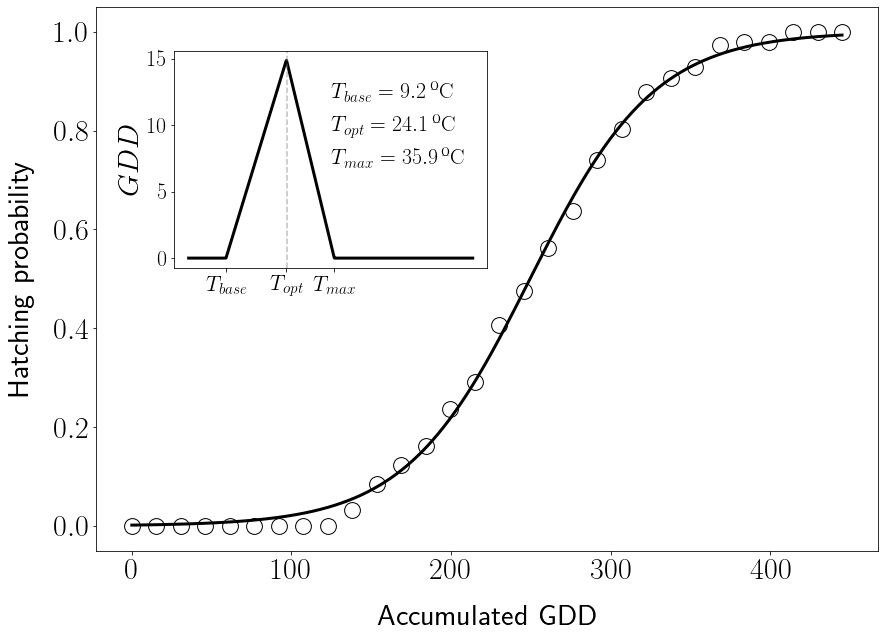

In [7]:
T = np.linspace(0, 70, 700)
        
params = (9.2, 24.1, 35.9) 
    
GDD = compute_GDD_w_opt_max(T, params[0], params[1], params[2])

ninfas, GDD_slices, popt = egg_hatching_probability(df, T_base, T_opt, T_max, N_points=30)

xrange = np.linspace(min(GDD_slices), max(GDD_slices), 10000)

fig, ax = plt.subplots(figsize=(14, 10))

ax.scatter(GDD_slices, ninfas, s=250, facecolor='w', color='k', label="Experimental data")
ax.plot(xrange, sigmoid(xrange, *popt), color="k", lw=3, label=r"$\hat{F}(GDD)$")

ax.set_xlabel("Accumulated GDD", fontsize=30, labelpad=20)
ax.set_ylabel("Hatching probability", fontsize=30, labelpad=20)

ax.tick_params(axis='both', which='major', labelsize=30)

axins = ax.inset_axes([0.1, 0.52, 0.4, 0.4])

axins.plot(T, GDD, lw=3, c="k")
axins.axvline([params[1]+0.05], ls="--", color='gray', alpha=0.5)
axins.text(35, 12, r"$T_{base}=9.2 \, \textrm{ºC}$", fontsize=22)
axins.text(35, 9.5, r"$T_{opt}=24.1 \, \textrm{ºC}$", fontsize=22)
axins.text(35, 7, r"$T_{max}=35.9 \, \textrm{ºC}$", fontsize=22)

#axins.set_xlabel(r"T [ºC]", fontsize=30)
axins.set_ylabel(r"$GDD$", fontsize=30)

axins.set_xticks(params)
axins.set_xticklabels([r"$T_{base}$", r"$T_{opt}$", r"$T_{max}$"])

axins.tick_params(axis='both', which='major', labelsize=22)

#plt.legend(fontsize=20);

#plt.savefig("Model_calibration.pdf", bbox_inches="tight", dpi=300)

# Fig emergence nymphs

In [8]:
df = pd.read_excel("Resultados GD.xlsx")

df_grouped = df.groupby(["Localización", "Fecha emergencia"]).sum().reset_index()

bustarviejo_date = df_grouped["Fecha emergencia"][df_grouped["Localización"] == "bustarviejo"]
bustarviejo_nimphs = df_grouped["Numero ninfas"][df_grouped["Localización"] == "bustarviejo"]

pedrezuela_date = df_grouped["Fecha emergencia"][df_grouped["Localización"] == "pedrezuela"]
pedrezuela_nimphs = df_grouped["Numero ninfas"][df_grouped["Localización"] == "pedrezuela"]

encin_date = df_grouped["Fecha emergencia"][df_grouped["Localización"] == "encin"]
encin_nimphs = df_grouped["Numero ninfas"][df_grouped["Localización"] == "encin"]

mataelpino_date = df_grouped["Fecha emergencia"][df_grouped["Localización"] == "mataelpino"]
mataelpino_nimphs = df_grouped["Numero ninfas"][df_grouped["Localización"] == "mataelpino"]

df["Days to emergence"] = df["Fecha emergencia"] - df["Fecha puesta"]

df_grouped = df.groupby(["Localización", "Days to emergence"]).sum().reset_index()

df_grouped

,Localización,Days to emergence,Numero ninfas
0,ICA,52 days,5
1,ICA,54 days,4
2,ICA,66 days,13
3,ICA,67 days,2
4,ICA,68 days,2
...,...,...,...
99,pedrezuela,183 days,1
100,pedrezuela,187 days,3
101,pedrezuela,189 days,7
102,pedrezuela,195 days,9


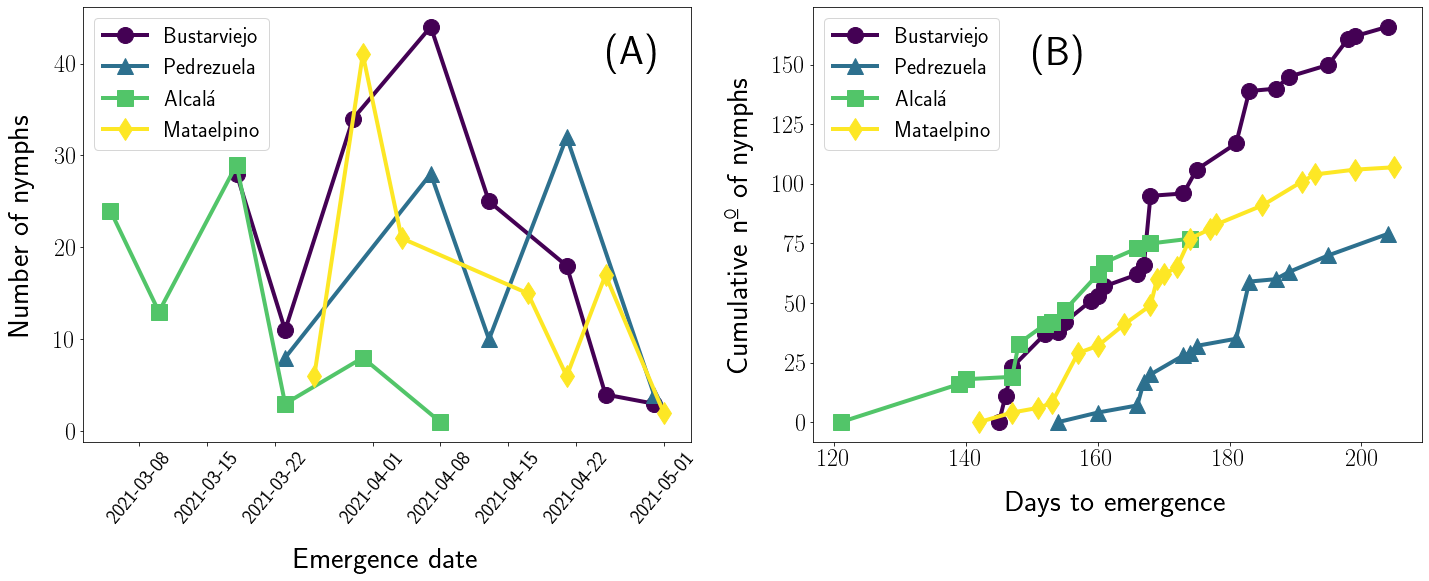

In [9]:
plt.figure(figsize=(12*2, 8))

colors = plt.get_cmap("viridis", 12)

plt.subplot(1,2,1)
plt.plot(bustarviejo_date, bustarviejo_nimphs, color=colors(0), lw=4, ls='-', marker='o', ms=16, label="Bustarviejo")
plt.plot(pedrezuela_date, pedrezuela_nimphs, color=colors(4), lw=4, ls='-', marker='^', ms=16, label="Pedrezuela")
plt.plot(encin_date, encin_nimphs, color=colors(8), lw=4, ls="-", marker='s', ms=16, label="Alcalá")
plt.plot(mataelpino_date, mataelpino_nimphs, color=colors(12), lw=4, ls="-", marker='d', ms=16, label="Mataelpino")

plt.text(bustarviejo_date.values[-2], 40, "(A)", fontsize=40)

plt.yticks(fontsize=24)
plt.xticks(fontsize=20, rotation=50)

plt.xlabel("Emergence date", fontsize=30, labelpad=20)
plt.ylabel("Number of nymphs", fontsize=30, labelpad=20)

plt.legend(loc='upper left', fontsize=22)


locs = ["bustarviejo", "pedrezuela", "encin", "mataelpino"]
labels = ["Bustarviejo", "Pedrezuela", "Alcalá", "Mataelpino"]

lstyles = ["-", "--", "-.", ":"]
markers = ["o", "^", "s", "d"]

colors = plt.get_cmap("viridis", 12)

k = 0

plt.subplot(1,2, 2)
for loc in locs:

    N = len(df_grouped[df_grouped["Localización"] == loc])

    cum_nymphs = np.zeros(N)

    for i in range(0, N):

        cum_nymphs[i] = np.sum(df_grouped[df_grouped["Localización"] == loc]["Numero ninfas"][0:i])
        
    cum_days = [i.days for i in df_grouped[df_grouped["Localización"] == loc]["Days to emergence"]]

    plt.plot(cum_days, cum_nymphs, color=colors(4*k), lw=4, ls="-", marker=markers[k], ms=16, label=labels[k])
    
    k += 1
    
plt.text(150, 150, "(B)", fontsize=40)

plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

plt.xlabel("Days to emergence", fontsize=30, labelpad=20)
plt.ylabel("Cumulative nº of nymphs", fontsize=30, labelpad=20)

plt.legend(loc='upper left', fontsize=22)

#plt.savefig("Data_analysys_nymphs.pdf", bbox_inches="tight", dpi=300)

# T, H plots  

In [10]:
data = pd.read_csv("Processed_climatic_data/Temperaturas experimentales.csv")

data["Date"] = pd.to_datetime(data["Date"])

data = data.sort_values(by='Date')

data["Date 2"] = [datetime.datetime.strftime(datetime.datetime.strptime(str(i), "%Y-%m-%d %H:%M:%S"), "%Y-%m") for i in data["Date"]]

data

,Date,Month,Location,Temperature,Debajo umbral minimo,Encima Umbral maximo,Dentro umbral desarrollo,Humidity,Date 2
32009,2020-10-09 15:00:00,October,Pedrezuela,25.0,NO,NO,YES,46.0,2020-10
22618,2020-10-09 15:00:00,October,Bustarviejo,25.0,NO,NO,YES,46.5,2020-10
32010,2020-10-09 15:30:00,October,Pedrezuela,25.0,NO,NO,YES,45.5,2020-10
22619,2020-10-09 15:30:00,October,Bustarviejo,25.0,NO,NO,YES,46.0,2020-10
22620,2020-10-09 16:00:00,October,Bustarviejo,25.0,NO,NO,YES,45.5,2020-10
...,...,...,...,...,...,...,...,...,...
32004,2021-05-01 17:47:00,May,Mataelpino,15.0,NO,NO,YES,48.0,2021-05
32005,2021-05-01 18:17:00,May,Mataelpino,15.0,NO,NO,YES,44.0,2021-05
32006,2021-05-01 18:47:00,May,Mataelpino,13.5,NO,NO,YES,53.0,2021-05
32007,2021-05-01 19:17:00,May,Mataelpino,12.0,NO,NO,YES,53.5,2021-05


## H vs T

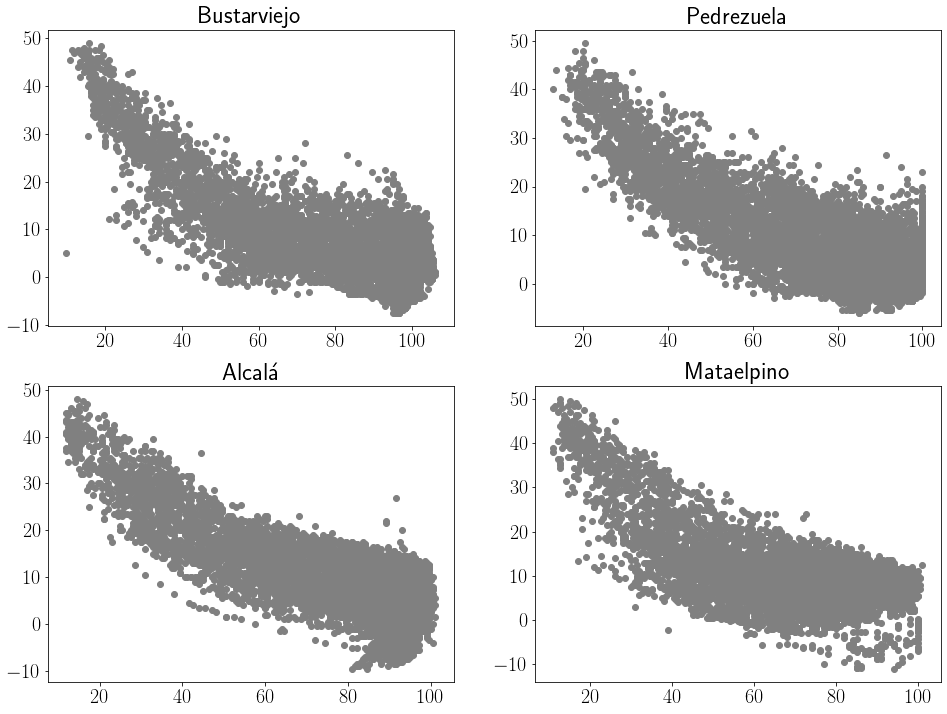

In [11]:
locs = ["Bustarviejo", "Pedrezuela", "IMIDRA", "Mataelpino"]
labels = ["Bustarviejo", "Pedrezuela", "Alcalá", "Mataelpino"]

ax_label = ['a', 'b', 'c', 'd']

colors = plt.get_cmap("viridis", 12)

fig, axs = plt.subplot_mosaic("""ab\ncd""", figsize=(16, 12))

for i in range(len(locs)):

    axs[ax_label[i]].scatter(data["Humidity"][data["Location"] == locs[i]], 
                     data["Temperature"][data["Location"] == locs[i]], color='gray')
    
    axs[ax_label[i]].set_title("%s" % labels[i])
    
#plt.savefig()

# T vs t 

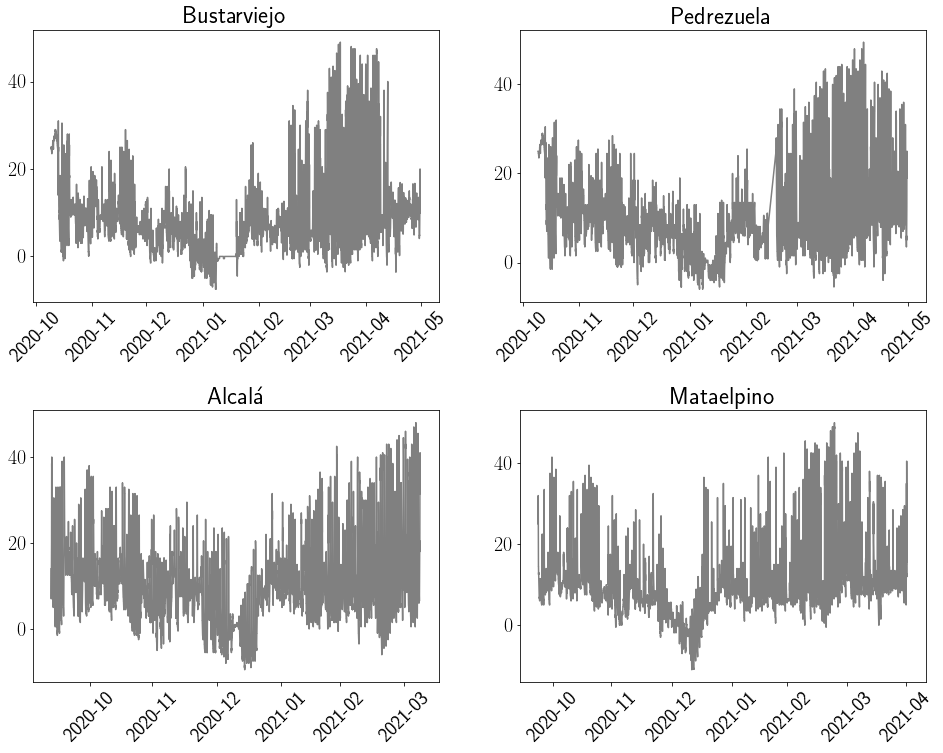

In [12]:
locs = ["Bustarviejo", "Pedrezuela", "IMIDRA", "Mataelpino"]
labels = ["Bustarviejo", "Pedrezuela", "Alcalá", "Mataelpino"]

ax_label = ['a', 'b', 'c', 'd']

colors = plt.get_cmap("viridis", 12)

xticks = [d.strftime('%Y-%m') for d in pd.date_range("20201001", "20210601", freq='M')]

fig, axs = plt.subplot_mosaic("""ab\ncd""", figsize=(16, 12))

for i in range(len(locs)):

    axs[ax_label[i]].plot(data["Date"][data["Location"] == locs[i]], 
                     data["Temperature"][data["Location"] == locs[i]], color='gray')
    
    axs[ax_label[i]].set_title("%s" % labels[i])
    
    axs[ax_label[i]].set_xticklabels(xticks, rotation=45)
    
plt.subplots_adjust(hspace=0.4)

## H vs t 

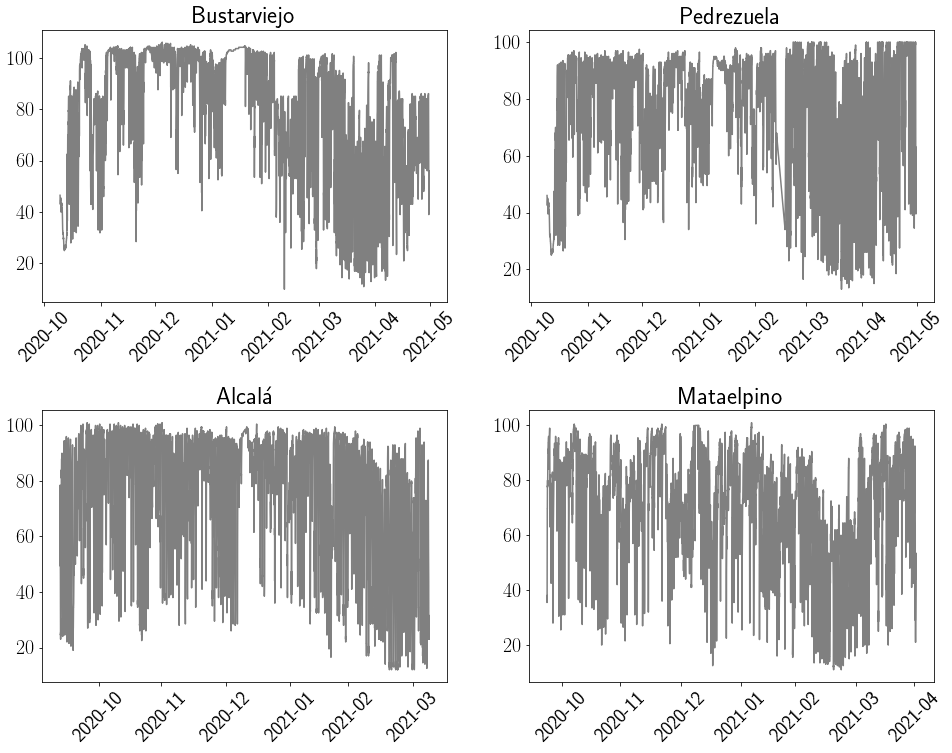

In [13]:
locs = ["Bustarviejo", "Pedrezuela", "IMIDRA", "Mataelpino"]
labels = ["Bustarviejo", "Pedrezuela", "Alcalá", "Mataelpino"]

ax_label = ['a', 'b', 'c', 'd']

colors = plt.get_cmap("viridis", 12)

xticks = [d.strftime('%Y-%m') for d in pd.date_range("20201001", "20210601", freq='M')]

fig, axs = plt.subplot_mosaic("""ab\ncd""", figsize=(16, 12))

for i in range(len(locs)):

    axs[ax_label[i]].plot(data["Date"][data["Location"] == locs[i]], 
                     data["Humidity"][data["Location"] == locs[i]], color='gray')
    
    axs[ax_label[i]].set_title("%s" % labels[i])
    axs[ax_label[i]].set_xticklabels(xticks, rotation=45)
    
plt.subplots_adjust(hspace=0.4)